In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
from math import sqrt
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from datetime import datetime
import seaborn as sns
pd.set_option('display.float_format', '{:,.1f}'.format)

## Анализ сервиса аренды самокатов GoFast

**Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверьте гипотезы, которые могут помочь бизнесу вырасти.**

**Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:**


**Без подписки**
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;


**с подпиской Ultra**
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.


**Описание данных.
В основных данных есть информация о пользователях, их поездках и подписках.**
- **Пользователи — users_go.csv**
 - **user_id**	уникальный идентификатор пользователя
 - **name**	имя пользователя
 - **age**	возраст
 - **city**	город
 - **subscription_type**	тип подписки (free, ultra)**
- **Поездки — rides_go.csv**
 - **user_id**	уникальный идентификатор пользователя
 - **distance**	расстояние, которое пользователь проехал в текущей сессии (в метрах)
 - **duration**	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
 - **date**	дата совершения поездки
- **Подписки — subscriptions_go.csv**
 - **ubscription_type**	тип подписки
 - **minute_price**	стоимость одной минуты поездки по данной подписке
 - **start_ride_price**	стоимость начала поездки
 - **subscription_fee**	стоимость ежемесячного платежа

**Нам предстоит выполнить следующие этапы:**
- Загрузка данных
- Предобработка данных
- Провести исследовательский анализ данных
- Выполнить объединение трех датасетов
- Произвести подсчет выручки 
- Проверить гипотезы


#### Шаг 1. Загрузка данных

In [2]:
#Считаем и сохраним данные в переменные
users = pd.read_csv('/datasets/users_go.csv') # Пользователи
rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])#Поездки
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')#Тип подписки

In [3]:
def dataset(data):
    print(data.info())
    return data.head(5)
    

In [4]:
#Выведем на экран первые 5 строк и первичную информацию
dataset(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


- **user_id** 	уникальный идентификатор пользователя
- **name**	имя пользователя
- **age**	возраст
- **city**	город
- **subscription_type**	тип подписки (free, ultra)

In [5]:
#Выведем на экран первые 5 строк и первичную информацию
dataset(rides)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
None


,user_id,distance,duration,date
0,1,"4,409.9",25.6,2021-01-01
1,1,"2,617.6",15.8,2021-01-18
2,1,754.2,6.2,2021-04-20
3,1,"2,694.8",18.5,2021-08-11
4,1,"4,028.7",26.3,2021-08-28


- **user_id**	уникальный идентификатор пользователя
- **distance**	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- **duration**	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- **date**	дата совершения поездки

In [6]:
#Выведем на экран первые 5 строк и первичную информацию
dataset(subscriptions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


- **subscription_type**	тип подписки
- **minute_price**	стоимость одной минуты поездки по данной подписке
- **start_ride_price**	стоимость начала поездки
- **subscription_fee**	стоимость ежемесячного платежа

#### Шаг 2. Предобработка данных

In [7]:
#Приведем столбец date к типу даты pandas.
rides['date'] = pd.to_datetime(rides['date'],format='%Y-%m-%d')

**Добавляем столбец с месяцем, выделив его из даты**

In [8]:
#Добавим столбец с номером месяца
rides['month']=pd.DatetimeIndex(rides['date']).month
#Выведем первые 5 строк датафрейма
rides.head(5)

,user_id,distance,duration,date,month
0,1,"4,409.9",25.6,2021-01-01,1
1,1,"2,617.6",15.8,2021-01-18,1
2,1,754.2,6.2,2021-04-20,4
3,1,"2,694.8",18.5,2021-08-11,8
4,1,"4,028.7",26.3,2021-08-28,8


In [9]:
print('Минимальная дата :', rides['date'].min())
print('Максимальная дата:', rides['date'].max())

Минимальная дата : 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00


Данные представлены за 2021 год

In [10]:
#Посчитаем количество пропусков
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
#Посчитаем количество пропусков
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [12]:
#Посчитаем количество пропусков
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [13]:
#Посчитаем количество явных дубликатов
users.duplicated().sum()

31

In [14]:
#Посчитаем количество явных дубликатов
rides.duplicated().sum()

0

In [15]:
#Посчитаем количество явных дубликатов
subscriptions.duplicated().sum()

0

In [16]:
#Удалим явные дубликаты
users.drop_duplicates(inplace = True)

In [17]:
#Посчитаем количество явных дубликатов
users.duplicated().sum()

0

**Вывод**
- привели столбец **date** датафрема **rides** к типу данных datetime64
- добавили столбец с номером месяца
- посчитали количество пропусков и дубликатов 
- удалили 31 явный дубликат из датафрейма **users**

**Данные готовы для дальнейшего исследования**

#### Шаг 3. Исследовательский анализ данных

**Частота встречаемости городов**

In [18]:
#Посчитаем встречаемость городов
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

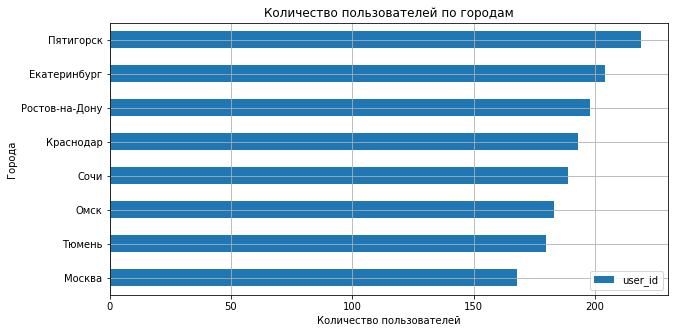

Количество пользователей по городам 


count     8.0
mean    191.8
std      15.7
min     168.0
25%     182.2
50%     191.0
75%     199.5
max     219.0
Name: city, dtype: float64

In [19]:
#сделаем сводную таблицу и построим график распделеения клиентов по городам
(
    users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True)
    .plot(kind='barh', grid=True, figsize=(10, 5))
)
plt.title('Количество пользователей по городам')
plt.ylabel('Города')
plt.xlabel('Количество пользователей')

plt.show()
print('Количество пользователей по городам ') 
users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

users['city'].value_counts().describe()

In [20]:
city_percentages = users['city'].value_counts()
city_percentages['rate'] = round(users['city'].value_counts() / 
                                    city_percentages.sum(), 2) * 100
city_percentages['rate']

Пятигорск        14.0
Екатеринбург     13.0
Ростов-на-Дону   13.0
Краснодар        13.0
Сочи             12.0
Омск             12.0
Тюмень           12.0
Москва           11.0
Name: city, dtype: float64

- Как мы видим из графика-распределение клиентов по городам практически одинаковое.
- Больше всего клиентов в Пятигорске, а меньше всего в Москве. Разница всего 3% 

**Соотношение пользователей с подпиской и без подписки**

In [21]:
#Посчитаем количество пользователей с подпиской и без
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

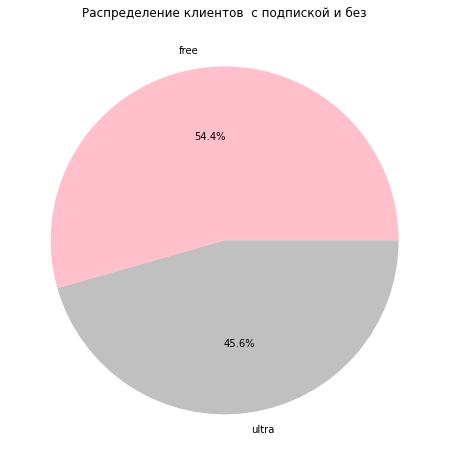

count     2.0
mean    767.0
std      96.2
min     699.0
25%     733.0
50%     767.0
75%     801.0
max     835.0
Name: subscription_type, dtype: float64

In [22]:
#Построим график
users['subscription_type'].value_counts().plot.pie(y='count', figsize=(8, 8),autopct='%1.1f%%',colors = ['pink', 'silver'])
plt.title('Распределение клиентов  с подпиской и без')
plt.axis('off')
plt.show()

users['subscription_type'].value_counts().describe()


- Из графика мы видим, что больше половины пользователей приложения не пользуются платной подпиской


**Возраст пользователей**

In [23]:
users['age'].describe().T

count   1,534.0
mean       24.9
std         4.6
min        12.0
25%        22.0
50%        25.0
75%        28.0
max        43.0
Name: age, dtype: float64

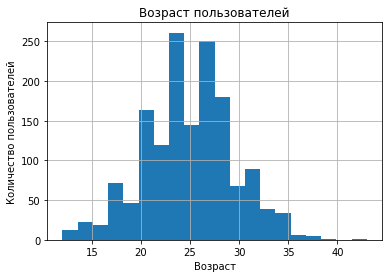

In [24]:
#Построим гистограмму возраста для наглядности
plt.hist(users['age'], bins = 20)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

**Расстояние, которое пользователь преодолел за одну поездку**

In [25]:
rides['distance'].describe().T

count   18,068.0
mean     3,070.7
std      1,116.8
min          0.9
25%      2,543.2
50%      3,133.6
75%      3,776.2
max      7,211.0
Name: distance, dtype: float64

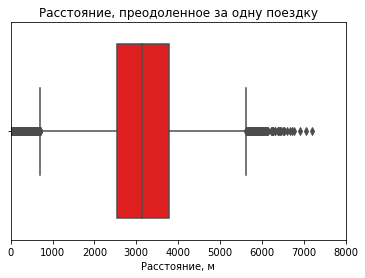

In [26]:
#Постороим диаграмму размаха
sns.boxplot(x=rides['distance'], color='red')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
diag= plt.xlim(0, 8000)

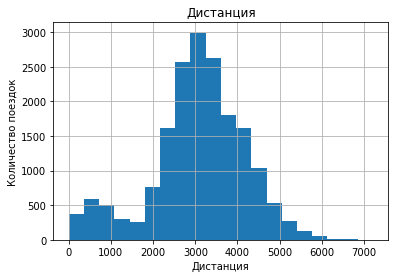

In [27]:
#Построим гистограмму для дистанции для наглядности
plt.hist(rides['distance'], bins = 20)
plt.title('Дистанция')
plt.xlabel('Дистанция')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

**Продолжительность поездок**

In [28]:
rides['duration'].describe().T

count   18,068.0
mean        17.8
std          6.1
min          0.5
25%         13.6
50%         17.7
75%         21.7
max         40.8
Name: duration, dtype: float64

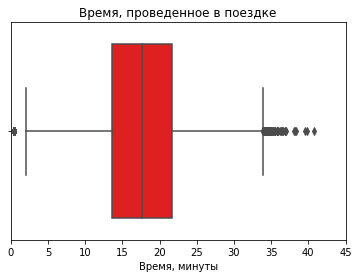

In [29]:
#Постороим диаграмму размаха
sns.boxplot(x = rides['duration'], color='red')
plt.title('Время, проведенное в поездке')
plt.xlabel('Время, минуты')
diag = plt.xlim(0, 45)

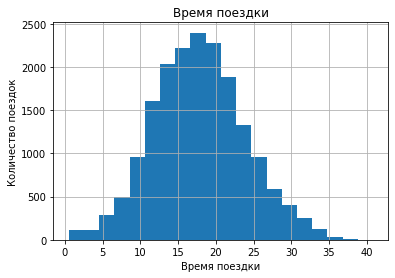

In [30]:
#Построим гистограмму для дистанции для наглядности
plt.hist(rides['duration'], bins = 20)
plt.title('Время поездки')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

**ВЫВОД**


**Частота встречаемости городов**


- Пользователи по городам распределены практически равномерно. Больше всего пользователей(226) в Пятигорске, а меньше всего(172) в Москве. Возможно это связано с тем, что в Пятигорске больше солнечных дней

**Соотношение пользователей с подпиской и без подписки**

- Пользователей без подписки чуть больше -846 или 54.1%

**Возраст пользователей**
- Основная часть пользователь находится в возрасте от 20 до 30 лет
- Минимальный возраст 12, а максимальный 43

**Расстояние, которое пользователь преодолел за одну поездку**
- Самая короткая дистанция - 0.86 км
- Самая длинная - 7.2 км
- В основном пользователи проезжают от 2500 м до 3800 м.

**Продолжительность поездок**

- Минимальное время  поездки 30 секунд, это выгляддит странно. Возможно пользователь отказался от поездки по каким либо причинам.
- Максимальное время поездки почти  41 минут.
- В основном  длительность поездки состовляет 13 - 22 минут.

#### Шаг 4. Объединение данных

In [31]:
#Объединим три датафрема в один
data = users.merge(rides)
data = data.merge(subscriptions)

In [32]:
print('Количество строк до объединения:', len(rides))
print('Количество строк после  объединения:', len(data))

Количество строк до объединения: 18068
Количество строк после  объединения: 18068


In [33]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

- Количество строк до и после объединени совпадает.
- Пропуски в объединенном датасете отсутствуют

Исходя из того, что пропуски отстутвуют и размеры датасета до и после объединения совпадают можно сделать вывод, что мы все выполнили правильно

In [34]:
#Выведем первые строки
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.9",25.6,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.6",15.8,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.2,6.2,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.8",18.5,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.7",26.3,2021-08-28,8,6,0,199


In [35]:
#Функция вывода пропусков , кол-ва строк и первых строк датасета
def head(data):
    print(data.isna().sum())
    print('Количество строк:', len(data) )
    return data.head()

In [36]:
#Создадим новый датафрейм с пользователями без подписки
subscription_free = data.query("`subscription_type` == 'free'")

In [37]:
#Выведем первые строки и количество пропусков
head(subscription_free)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64
Количество строк: 11568


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,"2,515.7",14.9,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.9,16.2,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,"4,004.4",20.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,"1,205.9",9.8,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,"3,047.4",17.4,2021-02-14,2,8,50,0


**В новом датасете пропуски отсутствуют**

In [38]:
#Создадим новый датафрейм с пользователями с подпиской
subscription_ultra = data.query("`subscription_type` == 'ultra'")

In [39]:
#Выведем первые строки и количество пропсков
head(subscription_ultra)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64
Количество строк: 6500


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.9",25.6,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.6",15.8,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.2,6.2,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.8",18.5,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.7",26.3,2021-08-28,8,6,0,199


**В новом датасете пропуски отсутствуют**

**Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий**

In [40]:
subscription_free['distance'].describe().T

count   11,568.0
mean     3,045.5
std      1,246.2
min          0.9
25%      2,366.6
50%      3,114.6
75%      3,905.7
max      7,211.0
Name: distance, dtype: float64

count   6,500.0
mean    3,115.4
std       836.9
min       244.2
25%     2,785.4
50%     3,148.6
75%     3,560.6
max     5,699.8
Name: distance, dtype: float64


count   11,568.0
mean     3,045.5
std      1,246.2
min          0.9
25%      2,366.6
50%      3,114.6
75%      3,905.7
max      7,211.0
Name: distance, dtype: float64

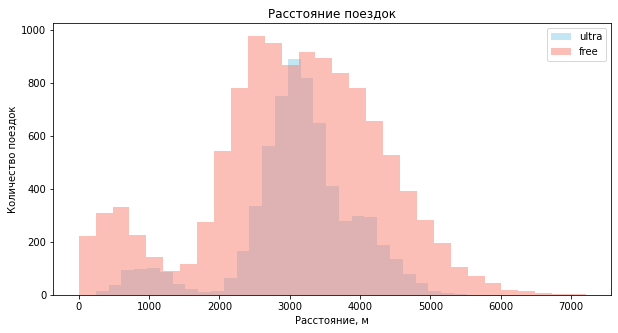

In [41]:
#построим совмещенную гистограмму расстояния поездок
plt.figure(figsize=(10,5))
plt.hist(subscription_ultra['distance'], bins=30, color='skyblue', alpha=0.5, label='ultra')
plt.hist(subscription_free['distance'], bins=30, color='salmon', alpha=0.5, label='free')
plt.title('Расстояние поездок')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.legend()

print(subscription_ultra['distance'].describe().T)
subscription_free['distance'].describe().T

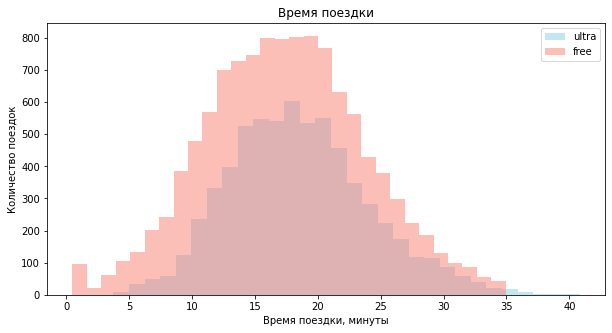

count   6,500.0
mean       18.5
std         5.6
min         3.8
25%        14.5
50%        18.2
75%        21.9
max        40.8
Name: duration, dtype: float64

count   11,568.0
mean        17.4
std          6.3
min          0.5
25%         13.0
50%         17.3
75%         21.6
max         34.9
Name: duration, dtype: float64


In [42]:
plt.figure(figsize=(10,5))
plt.hist(subscription_ultra['duration'], bins=30, color='skyblue', alpha=0.5, label='ultra')
plt.hist(subscription_free['duration'], bins=30, color='salmon', alpha=0.5, label='free')
plt.title('Время поездки')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.legend()

plt.show()
print(subscription_ultra['duration'].describe().T)
print()
print(subscription_free['duration'].describe().T)

**Вывод**

- Объединили данные о пользователях, поездках и тарифах в один датафрейм - data
- из датафрема data выделили два новых датафрейма:**subscription_free** c данными о пользователях без подписки и **subscription_ultra** с данными о пользователях с подпиской

- Визуализировали информацию о расстоянии и времени для каждого из тарифов

- На бесплатном тарифе время поездки составляет от 12 до 21 минут и расстояние от 2.3 до 3,1 км

- На платном тарифе  время поездки составляет от 14 до 21 минут и расстояние от 2.8 до 3,6 км

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом совершаю чуть более короткие поездки и по времени и по расстоянию

#### Шаг 5. Подсчёт выручки

**Создадим датафрейм *agg_data* с агрегированными данными о поездках на основе датафрейма *data* и найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.**

In [43]:
#округляем продолжительность поездки до следующего целого числа
data['duration'] = np.ceil(data['duration'])

In [44]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.9",26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.6",16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.2,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.8",19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.7",27.0,2021-08-28,8,6,0,199


In [45]:
agg_data = pd.pivot_table(data,
                           index=['month', 'user_id'],
                           values = ['distance',
                                     'duration',
                                     'name',
                                     'subscription_type',
                                     'minute_price',
                                     'start_ride_price',
                                     'subscription_fee'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min,
                                      'minute_price': min,
                                      'start_ride_price': min,
                                      'subscription_fee': min})

In [46]:
#переименовываем колунку name в count_tips
agg_data.rename(columns = {'name' : 'count_tips'}, inplace = True)

#сортируем по месяцу и выводим первые 10 строк
agg_data.sort_values(by='month').head(10)

distance  duration  minute_price  count_tips  start_ride_price  \
month user_id                                                                   
1     1         7,027.5      42.0             6           2                 0   
      1061     12,637.2      43.0             8           3                50   
      1063      3,276.4      10.0             8           1                50   
      1064      5,297.3      15.0             8           1                50   
      1065     14,547.1      99.0             8           4                50   
      1066      2,809.1      19.0             8           1                50   
      1067      3,864.9      22.0             8           1                50   
      1069      7,007.1      53.0             8           3                50   
      1071      3,635.1      15.0             8           1                50   
      1072      2,498.6      11.0             8           1                50   

               subscription_fee subscription_type  
month user_id                                      
1     1                     199             ultra  
      1061                    0              free  
      1063                    0              free  
      1064                    0              free  
      1065                    0              free  
      1066                    0              free  
      1067                    0              free  
      1069                    0              free  
      1071                    0              free  
      1072                    0              free

In [47]:
agg_data.isna().sum()

distance             0
duration             0
minute_price         0
count_tips           0
start_ride_price     0
subscription_fee     0
subscription_type    0
dtype: int64

В агрегированном датасете пропуски отсутствуют

In [48]:
agg_data.head(10)

distance  duration  minute_price  count_tips  start_ride_price  \
month user_id                                                                   
1     1         7,027.5      42.0             6           2                 0   
      3         3,061.8      13.0             6           1                 0   
      5         3,914.6      13.0             6           1                 0   
      7         6,478.1      28.0             6           2                 0   
      12        3,577.2      33.0             6           1                 0   
      13        6,688.0      42.0             6           2                 0   
      14        7,699.6      35.0             6           2                 0   
      15        4,187.6      39.0             6           1                 0   
      20        3,516.7      29.0             6           1                 0   
      22        3,058.7      13.0             6           1                 0   

               subscription_fee subscription_type  
month user_id                                      
1     1                     199             ultra  
      3                     199             ultra  
      5                     199             ultra  
      7                     199             ultra  
      12                    199             ultra  
      13                    199             ultra  
      14                    199             ultra  
      15                    199             ultra  
      20                    199             ultra  
      22                    199             ultra

In [49]:
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return row['minute_price'] * row['duration'] + row['subscription_fee']
    elif row['subscription_type'] == 'free':
        return row['minute_price'] * row['duration'] + row['start_ride_price'] * row['count_tips']
    else:
        return 'Not such sub'
agg_data['revenue_month'] = agg_data.apply(revenue, axis=1)
agg_data.head(10)

distance  duration  minute_price  count_tips  start_ride_price  \
month user_id                                                                   
1     1         7,027.5      42.0             6           2                 0   
      3         3,061.8      13.0             6           1                 0   
      5         3,914.6      13.0             6           1                 0   
      7         6,478.1      28.0             6           2                 0   
      12        3,577.2      33.0             6           1                 0   
      13        6,688.0      42.0             6           2                 0   
      14        7,699.6      35.0             6           2                 0   
      15        4,187.6      39.0             6           1                 0   
      20        3,516.7      29.0             6           1                 0   
      22        3,058.7      13.0             6           1                 0   

               subscription_fee subscription_type  revenue_month  
month user_id                                                     
1     1                     199             ultra          451.0  
      3                     199             ultra          277.0  
      5                     199             ultra          277.0  
      7                     199             ultra          367.0  
      12                    199             ultra          397.0  
      13                    199             ultra          451.0  
      14                    199             ultra          409.0  
      15                    199             ultra          433.0  
      20                    199             ultra          373.0  
      22                    199             ultra          277.0

In [50]:
subscription_type = agg_data.groupby(['month','subscription_type']).revenue_month.sum()

In [51]:
subscription_type.groupby('subscription_type').mean()

subscription_type
free    186,175.3
ultra   137,044.8
Name: revenue_month, dtype: float64

In [52]:
print('Общая выручка компании:', agg_data['revenue_month'].sum())
print('Выручка от клиентов с подпиской Ultra:', agg_data[agg_data['subscription_type'] == 'ultra'].revenue_month.sum())
print('Выручка от клиентов  без подписки  :', agg_data[agg_data['subscription_type'] == 'free'].revenue_month.sum())

Общая выручка компании: 3878641.0
Выручка от клиентов с подпиской Ultra: 1644537.0
Выручка от клиентов  без подписки  : 2234104.0


**Вывод**
- Создали датафрейм **agg_data** с агрегированными данными о поездках на основе датафрейма **data**
- Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц с подпиской и без.
- Посчитали всю выручку за год
- Посчиталь выручку за год по бесплатному и платнгому тарифу

#### Шаг 6. Проверка гипотез

**6.1 Тратят ли пользователи с подпиской больше времени на поездки?**

Если да, то пользователи с подпиской могут быть «выгоднее» для компании

**Выдвигаем гипотезы:**

- Н0: Средняя продолжительность поездок с подпиской   равно  продолжительности поездок без подписок 
- Н1: Средняя продолжительность поездок с подпиской  больше продолжительности поездок без подписок 

In [53]:
ultra = subscription_ultra['duration'] 

free = subscription_free['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [54]:
results

Ttest_indResult(statistic=12.241203729044017, pvalue=1.2804098316645618e-34)

p-значение 1.2804098316645618e-34 на языке статистики означает чрезвычайно малую вероятность ошибки 

In [55]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


**Вывод:**



Отвергаем гипотезу о том, что время поездки пользователей с платной подпиской меньше времени поездки пользователей без подписки. Получается, что пользователи с подпиской более выгодны для бизнеса

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

**Выдвинем гипотезы:**



- Н0: Среднее расстояние поездок с подпиской  равно оптимальному расстоянию в 3130 метров.
- Н1: Среднее расстояние поездок с подпиской  больше оптимального в 3130 метров.


Проверим гипотезы, используем исходные данные о расстоянии в для подписчиков.

In [56]:
interested_value = 3130 
revenue = subscription_ultra['distance']
alpha = 0.05

results = st.ttest_1samp(
    revenue, 
    interested_value, alternative='greater')

print('p-значение:', results.pvalue )

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Нулевую гипотезу неудалось отвергнуть.

**6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

- H0  помесячная средняя выручка пользователей с подпиской равна средней выручке пользователей без подписки
- H1  помесячная средняя выручка пользователей с подпиской больше средней выручки пользователей без подписки

In [57]:
ultra_per_mnth = agg_data.loc[agg_data.subscription_type == 'ultra', 'revenue_month'] 

free_per_mnth = agg_data.loc[agg_data.subscription_type == 'free', 'revenue_month'] 

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(ultra_per_mnth, free_per_mnth)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 3.7700788769430433e-31
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезуи и принимаем альтернативную о том,  что средняя выручка от пользователей с подпиской Ultra больше средней  выручки от пользователей без подписки,

In [58]:
results

Ttest_indResult(statistic=11.64246602360774, pvalue=3.7700788769430433e-31)

**6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

**Ответ:**

Гипотеза о равенстве средних для зависимых (парных) выборок

**Гипотезы  будут сформулированы так:**
- H0 : μ1 = μ2
- H1 : μ1 != μ2


где μ1 и μ2 — средние значения до и после изменения.

Метод, необходимый для сравнения: scipy.stats.ttest_rel()

#### Шаг 7. Распределения

**7.1  Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.**

Если раздать  1161 промокодов,то вероятность не выполнить план меньше 5.0 %


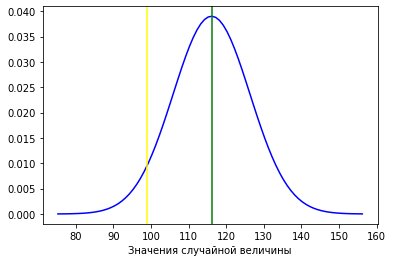

In [59]:
n = 1000
p = 0.1
k = 99
binom_cdf = 0.05

while binom_cdf < binom.cdf(k, n, p):
    n += 1
print(f'Если раздать  {n} промокодов,то вероятность не выполнить план меньше {binom.cdf(k, n, p).round(2)*100} %')

mu = n * p # математическое ожидание
sigma = (n * p * (1 - p))**0.5  # стандартное отклонение

arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)

plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.axvline(x=k, color='yellow')
plt.axvline(x=mu, color='green')
plt.title('')
plt.xlabel('Значения случайной величины')
plt.ylabel('')
plt.show()

**Вывод**
- для того чтобы как минимум 100 существующих клиентов продоиои подписку необходимо разослать как минимум 1161 промокод

**7.2  Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 
40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.**

Вероятность открытия сообщений: 0.15371708296369768


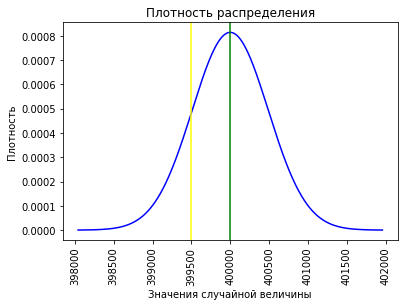

In [60]:
# задаём параметры биномиального распределения
n = 1000000 #количество промокодов
p = 0.4 #веролятносить успеха
k = 399500 #

mu = n * p #математическое ожидание
sigma = (n * p * (1 - p))**0.5 # стандартное отклонение


distr = st.norm(mu, sigma)  #нормальное распределение


result = distr.cdf(k) #вероятность левого хвоста от 399.5 тысяч
print('Вероятность открытия сообщений:', result)

arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.xticks(rotation=90)
plt.axvline(x=k, color='yellow')
plt.axvline(x=mu, color='green')
plt.title('Плотность распределения')
plt.xlabel('Значения случайной величины')
plt.ylabel('Плотность')
plt.show()

**Выввод** 
- Если уведомления открывает около 40% получивших его клиентов , то если  разослать 1.000.000 уведомлений, то с вероятностью 15% их  откроет не более 399500 клиентов 

# Общий вывод


**В процкссе  исселдования мы проделали следующие этапы:**
- **Загрузили данные из трех датафремов и провели их предобработку, а именно:**
 - в датафреме **users_go**  удалили 31 явный дубликат
 - Привели столбец date к типу datetime64
 - Создали столбец month с номером месяца из date

- **Провели исследовательский  анализ данных**
 - Выяснили , что услугами   аренды самокатов пользуются больше всего в Пятигоске,думаю это связано с тем, что солнечных дней там больше
 - Количество пользователей без подписки  превышает количество пользователей с платной подпиской. 54.4% и 45,6% соответственно
 - Основной возростная группа пользователей это люди от 20 до 30 лет. Средний возраст составляет 25 лет
 - На бесплатном тарифе время поездки составляет от 12 до 21 минут и расстояние от 2.3 до 3,1 км, а на платном тарифе время поездки составляет от 14 до 21 минут и расстояние от 2.8 до 3,6 км
- **Посчитали выручку**
 - Создали датафрейм agg_dataс агрегированными данными о поездках на основе датафрейма data
 - Создали функцию для подсчеты выручки согласно тарифа за месяц
 - Посчитали сколько тратил каждый пользователь в месяц на разных тарифах
 - Общая выручка компании за год составила 3.900.765 рублей .Выручка от пользователей с подпиской и без составила 1.657.341 и 2.243.424 рублей соответственно

- **Пользователи  с платной подпиской тратят больше времни на поездки и следовательно он иболее выгодны для компании**

- **Среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстоянием в 3130 метров и явлдяется оптимальным с точки зрения износа самоката**

- **Cредняя выручка от пользователей с подпиской Ultra больше средней выручки от пользователей без подписки**





**Исходя из проведенного анализа представленных датасетов и проверки гипотез можно утверждатиь, что порльзователи с платной подпиской более выгодны для компании , чем пользователи без подписки . Всвязи с этим считаю необходимым принять меры для стимулирования пользователей к приобретению подписки Ultra**


## Бонус

### Задача 7.1 — декомпозиция

+ Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. 

+ То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

+ Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 

+ Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

+ Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

+ 100 существующих клиентов должны продлить эту подписку.
 + т.е. мы ищем х - кол-во промокодов, которое мы раздадим, чтобы сохранить 100 клиентов

+ может либо отказаться от неё, либо продлить
 + т.е. два исхода

+ подписку продлевают 10 % пользователей
 + т.е. из кол-ва Х, которое мы найдем и по которому разошлем промокоды, полагаясь на предыдущий опыт, продлят подписку 10%

+ вероятность не выполнить план была примерно 5 %
 + т.е. мы должны найти вероятность успеха нашей акции 1-0,05 = 95%
 + этот план будет иметь свою вероятность исполнения при разном кол-ве Х, т.е. если мы выберем Х = 1000, вероятность успеха будет равна А, при 2000 промокодах, вероятность будет равна В. Но, увеличивая кол-во промокодов, мы увеличиваем трудозатраты ... По этой причине нас устроит вероятность успеха 95%, для которой и предстоит рассчитать кол-во промокодов Х

Получается задача делиться на две части

+ число положительных исходов должно быть равно 100-ам

+ но вероятность такого события должна быть равна 95% 



Урок

Percent Point Function для нормального распределения
+ Ранее вы познакомились с функцией распределения, или кумулятивной функцией распределения.



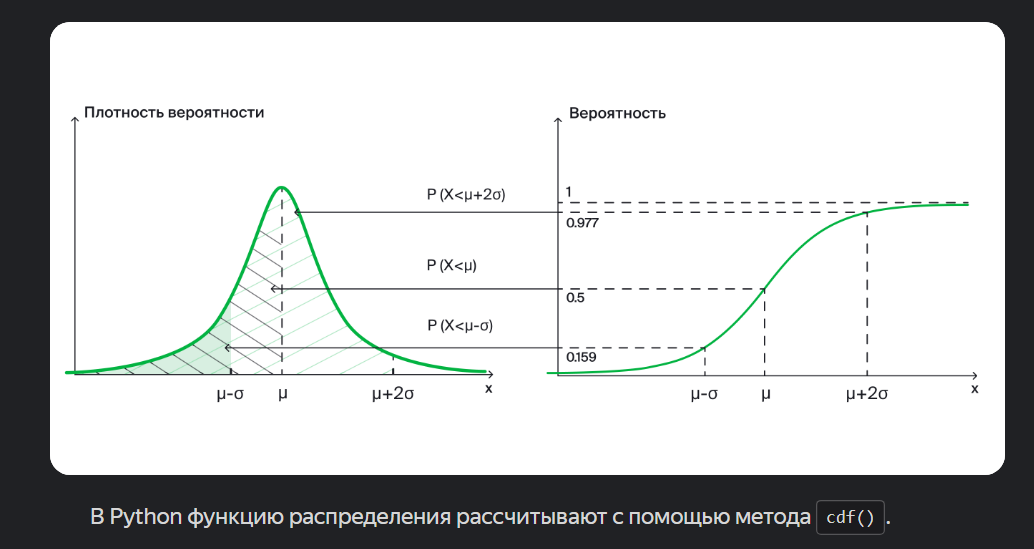

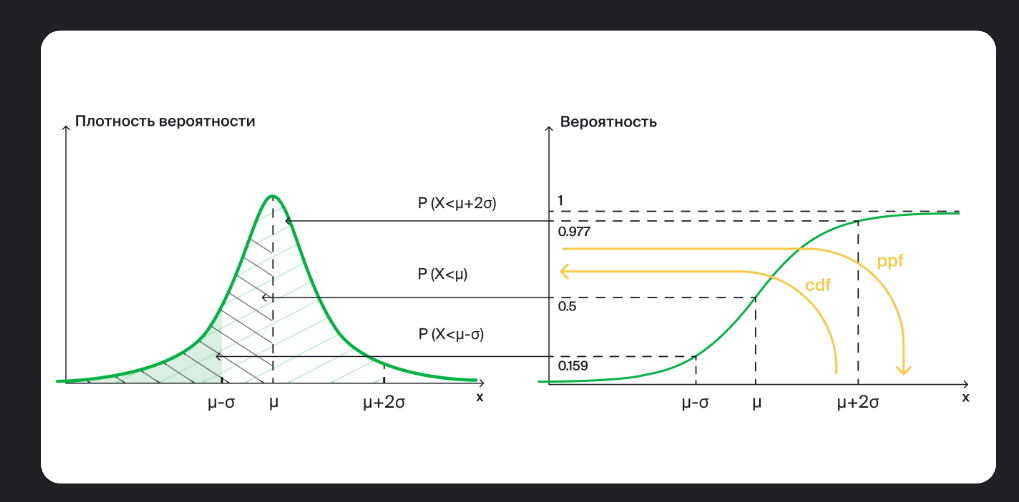

In [61]:
for i in range (1, 13):
    trials = 100 * i
    print(f"i: {i, trials}\tprobability: {(st.binom.cdf(99, trials, 0.1)).round(3)}")

i: (1, 100)	probability: 1.0
i: (2, 200)	probability: 1.0
i: (3, 300)	probability: 1.0
i: (4, 400)	probability: 1.0
i: (5, 500)	probability: 1.0
i: (6, 600)	probability: 1.0
i: (7, 700)	probability: 1.0
i: (8, 800)	probability: 0.987
i: (9, 900)	probability: 0.854
i: (10, 1000)	probability: 0.485
i: (11, 1100)	probability: 0.145
i: (12, 1200)	probability: 0.022


In [62]:
for i in range (1, 13):
    trials = 100 * i
    print(f"i: {i, trials}\ttarget_probability: {(1 - st.binom.cdf(99, trials, 0.1)).round(3)}");    
   
print(f"i: {13, 1161}\ttarget_probability: {(1 - st.binom.cdf(99, 1161, 0.1)).round(3)}")

i: (1, 100)	target_probability: 0.0
i: (2, 200)	target_probability: 0.0
i: (3, 300)	target_probability: 0.0
i: (4, 400)	target_probability: 0.0
i: (5, 500)	target_probability: 0.0
i: (6, 600)	target_probability: 0.0
i: (7, 700)	target_probability: 0.0
i: (8, 800)	target_probability: 0.013
i: (9, 900)	target_probability: 0.146
i: (10, 1000)	target_probability: 0.515
i: (11, 1100)	target_probability: 0.855
i: (12, 1200)	target_probability: 0.978
i: (13, 1161)	target_probability: 0.95


### check

In [63]:
dfg1 = pd.DataFrame(
    {
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
        "C": ["C0", "C1", "C2", "C3"],
        "D": ["D0", "D1", "D2", "D3"],
    },
    index=[0, 1, 2, 3],
)

dfr4 = pd.DataFrame(
    {
        "B": ["B2", "B3", "B6", "B7"],
        "D": ["D2", "D3", "D6", "D7"],
        "F": ["F2", "F3", "F6", "F7"],
        "E": [np.nan, np.nan, np.nan, np.nan]
    },
    index=[2, 3, 6, 0],
)

In [64]:
display(dfg1, dfr4)

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3


,B,D,F,E
2,B2,D2,F2,NaN
3,B3,D3,F3,NaN
6,B6,D6,F6,NaN
0,B7,D7,F7,NaN


In [65]:
dfg1.merge(dfr4, left_on=dfg1.index, right_on=dfr4.index, how='outer')

,key_0,A,B_x,C,D_x,B_y,D_y,F,E
0,0,A0,B0,C0,D0,B7,D7,F7,NaN
1,1,A1,B1,C1,D1,NaN,NaN,NaN,NaN
2,2,A2,B2,C2,D2,B2,D2,F2,NaN
3,3,A3,B3,C3,D3,B3,D3,F3,NaN
4,6,NaN,NaN,NaN,NaN,B6,D6,F6,NaN


In [66]:
dfg1.merge(dfr4, 'outer')

,A,B,C,D,F,E
0,A0,B0,C0,D0,NaN,NaN
1,A1,B1,C1,D1,NaN,NaN
2,A2,B2,C2,D2,F2,NaN
3,A3,B3,C3,D3,F3,NaN
4,NaN,B6,NaN,D6,F6,NaN
5,NaN,B7,NaN,D7,F7,NaN


In [67]:
dfg1.merge(dfr4)

,A,B,C,D,F,E
0,A2,B2,C2,D2,F2,NaN
1,A3,B3,C3,D3,F3,NaN


In [68]:
dfg1.merge(dfr4, 'inner')

,A,B,C,D,F,E
0,A2,B2,C2,D2,F2,NaN
1,A3,B3,C3,D3,F3,NaN


### check

In [69]:
agg_data.columns

Index(['distance', 'duration', 'minute_price', 'count_tips',
       'start_ride_price', 'subscription_fee', 'subscription_type',
       'revenue_month'],
      dtype='object')

In [70]:
dfg_first = agg_data.copy()

In [71]:
x = 'subscription_type'
y = 'revenue_month'

In [72]:
dfg_first.groupby(x)[y].mean().round(1).to_frame()

,revenue_month
subscription_type,
free,328.6
ultra,362.8


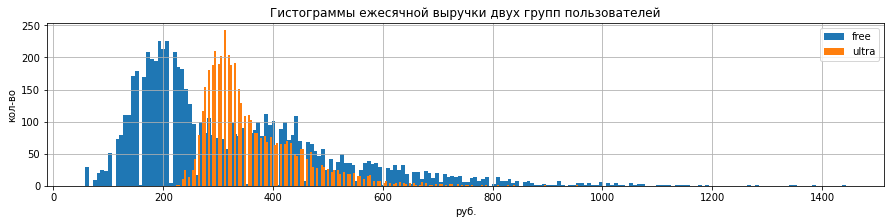

In [73]:
dfg_first.groupby(x)[y].hist(bins=200, figsize=(15,3), legend=True)
plt.title('Гистограммы ежесячной выручки двух групп пользователей')
plt.xlabel('руб.')
plt.ylabel('кол-во');

In [74]:
# копируем таблицу
dfg = dfg_first.copy()


In [75]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (12, 1534)
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           11331 non-null  float64
 1   duration           11331 non-null  float64
 2   minute_price       11331 non-null  int64  
 3   count_tips         11331 non-null  int64  
 4   start_ride_price   11331 non-null  int64  
 5   subscription_fee   11331 non-null  int64  
 6   subscription_type  11331 non-null  object 
 7   revenue_month      11331 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 753.9+ KB


In [76]:
# удаляем данные, 20%
for col in dfg.columns:
    dfg.loc[dfg.sample(frac=0.2).index, col] = np.nan

In [77]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (12, 1534)
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           9065 non-null   float64
 1   duration           9065 non-null   float64
 2   minute_price       9065 non-null   float64
 3   count_tips         9065 non-null   float64
 4   start_ride_price   9065 non-null   float64
 5   subscription_fee   9065 non-null   float64
 6   subscription_type  9065 non-null   object 
 7   revenue_month      9065 non-null   float64
dtypes: float64(7), object(1)
memory usage: 1.0+ MB


In [78]:
dfg.groupby(x)[y].mean().round(1).to_frame()

,revenue_month
subscription_type,
free,329.4
ultra,363.1


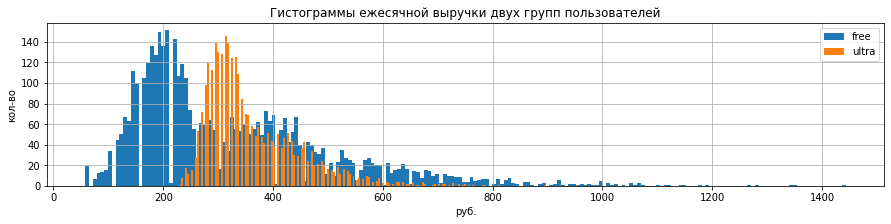

In [79]:
dfg.groupby(x)[y].hist(bins=200, figsize=(15,3), legend=True)
plt.title('Гистограммы ежесячной выручки двух групп пользователей')
plt.xlabel('руб.')
plt.ylabel('кол-во');